# Desafío MeLi data science - Milton Katz

_<font size="1">Mercado Libre ofrece a los sellers del Marketplace la posibilidad de almacenar productos en sus bodegas, teniendo en cuenta que el espacio es limitado, se debe sugerir para cada ítem la cantidad óptima de inventario que debe ser almacenado.</font>_

Para resolver este problema es importante entender qué probabilidad hay, en función de la cantidad de productos almacenados, de quedarse sin stock. Con esta información puede elegirse una probabilidad tolerada y definir el mínimo de stock que puede ser almacenado en los depósitos. A continuación discutiré las distintas formas de llegar a este resultado, sus ventajas y desventajas.

Un proceso estocástico donde hay un gran número de eventos posibles con una muy baja probabilidad de ocurrencia es conocido como un proceso de Poisson, en este tipo de procesos, la distribución que sigue la variable aleatoria $r$ de ocurrencias por unidad de tiempo es una distribución conocida como distribución de Poisson.

$$ P(r) = \frac{\mu^r \mathrm{e}^{-\mu}}{r!}$$

Al haber muchas personas con probabilidad prácticamente nula de comprar un determinado producto un determinado día, las compras de cada producto siguen una distribución de Poisson como la descripta previamente, la variable de interés será cuántas ventas ocurren en un período de tiempo, en particular se trabajará con ventas por día.

Para saber cuándo un vendedor debe reponer el stock, calcularé cuál es el stock necesario para que la probabilidad de quedarse sin stock sea mayor a $q$. Donde $q$ es una probabilidad elegida como límite de probabilidad aceptable, a su vez discutiré distintas formas de elegir el parámetro $q$. Dicha pregunta se responde con el percentil $p$ de una distribución donde $p = 100(1-q)$. La ventaja de resolver este problema pensando en percentiles y no en valores medios es que el percentil incluye información tanto sobre el valor medio como sobre la varianza y para saber cuánto almacenar en un depósito el conocimiento sobre las fluctuaciones que pueden ocurrir sobre las ventas es extremadamente importante.

Una vez asumida la distribución de Poisson es posible usar un buen estimador para el parámetro $\mu$ y a partir del mismo buscar el percentil de la distribución que éste genera. El problema de esta solución es que el conocimiento sobre $\mu$ que se tiene está limitado por la cantidad de datos y si se soluciona el problema de esta mandera la incerteza sobre $\mu$ no es traducida al percentil.

Para resolver esto correctamente se puede asumir que el parámetro $\mu$ también es una variable aleatoria que sigue su distribución de probabilidad, ésta dará información sobre qué se conoce sobre $\mu$ pero también sobre cuánta incerteza hay. Obtener la distribución de las ventas por día a partir de una distribución de $\mu$ en vez de obtenerla desde un solo valor, permitirá traducir la incerteza de dicho $\mu$ en el resultado del percentil.

La probabilidad de $\mu$ que se busca puede inferirse a partir de la probabilidad condicional de $\mu$ dado los datos que se observaron, usando el teorema de Bayes puede obtenerse

$$ P(\mu|D) = \frac{P(D|\mu)P(\mu)}{\int P(D|\mu)P(\mu) d\mu} $$

La probabilidad $P(\mu)$ es la que cuantifica la información que tengo hasta el momento (prior), la probabilidad $P(D|\mu)$ puede calcularse al finalizar cada día con la venta de ese día. Así, la probabilidad $P(\mu|D)$ que es la que finalmente usaré para calcular la probabilidad de ventas del día siguiente y el percentil, puede ser actualizada cada día y representará mi conocimiento actual sobre $\mu$. De esta manera el modelo irá aprendiendo de los datos.

Una debilidad de este modelo es que asume que los datos siguen una distribución de Poisson, si bien es cierto, por lo dicho previamente que su serie de tiempo tendrá errores Poissoneanos, es posible que ésta se vea afectada por fechas como el día de la madre, del padre, del niño o navidad que alteren el proceso. A su vez también habrán días en los que se alteren las ventas menos predecibles, como el aumento de ventas en televisores por un evento deportivo importante o el aumento en las ventas de juegos de ajedrez por haberse puesto de moda la serie Queen's Gambit.

A continuación se muestra el desarrollo de este modelo y a su vez, se proponen posibles soluciones a desarrollar para suplir los problemas del mismo.

## Generación de los datos
Como los datos que necesito para esta estimación no son datos públicos, voy a generar mis propios datos, para el caso real esta parte debería ser reemplazada por la obtención de los datos desde una api y/o una query de una base de datos. Me genero entonces, un array en cuyas filas estarán los productos y cuyas columnas contendrán las ventas por día.

In [18]:
import numpy as np
from scipy import stats as st
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
plt.style.use('seaborn')
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('figure', figsize=(6.4*1.5,4.8*1.5))


N_products = 2000
N_days = 730
beta = 10

lambda_base = np.random.exponential(beta,N_products)

day = np.arange(N_days)

sells_per_day = []
for lam in lambda_base:
    sells_per_day.append(np.random.poisson(lam,N_days))
sells_per_day = np.array(sells_per_day)
print(sells_per_day.shape)
print('una fila por producto, una columna por día')

(2000, 730)
una fila por producto, una columna por día


## Modelo Bayesiano para la predicción del número de ventas

Utilizaré un modelo Bayesiano para la predicción porque me permitirá representar mejor las incertezas que tengo sobre el sistema y usarlas como información para las predicciones, logrando prevenir mejor demandas inesperadas de un producto.

Para todo el modelo asumiré como hipótesis que los datos de las ventas por día siguen una distribución de Poisson. Para esto voy a comenzar asumiendo que el parámetro $\mu$ de cada producto tiene una distribución de probabilidad exponencial que estimaré con la distribución del valor medio de venta por día de todo el resto de los productos. Asumir esto es asumir que, en un producto desconocido, la probabilidad de vender cinco productos por día es la misma que tomar un producto al azar de la lista de productos existentes y que éste venda cinco productos.

Luego de esta suposición el modelo comenzará a aprender de los datos y cada día se actualizará, hasta llegar al estimación del parámetro $\mu$.

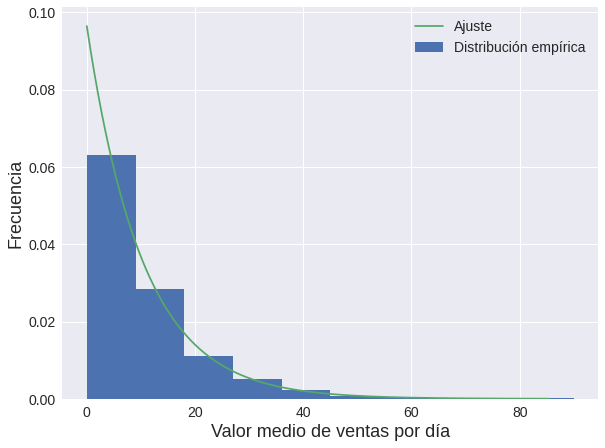

In [19]:
means = np.mean(sells_per_day,axis = 1)
mean_distribution,bins = np.histogram(means,density = True)
x = (bins[:-1]+bins[1:])/2
width = bins[:-1]-bins[1:]
def model(t, beta):
    return np.exp(-t/beta)/beta
init_beta = np.mean(means)

opt_beta, cov = curve_fit(model, xdata = x, ydata = mean_distribution,p0 = init_beta)

x_model = np.linspace(0,max(x),500)

fig_prior,ax_prior = plt.subplots()
ax_prior.bar(x,mean_distribution,align = 'center',width = width,label= 'Distribución empírica')
ax_prior.plot(x_model,model(x_model,opt_beta),color = '#55A868',label = 'Ajuste')
ax_prior.set(xlabel = 'Valor medio de ventas por día',ylabel = 'Frecuencia')
ax_prior.legend();


Cada día que pase la distribución se irá actualizando y aprendiendo de lo que se suceda, para los productos más antiguos el prior tendrá muy poco peso, para los nuevos será más importante. 

Esta distribución captura lo que sé hasta ahora sobre el parámetro $\mu$, si solo tuviera un valor de $\mu$ estaría asegurando que la distribución de Poisson que siguen mis datos es una distribución de Poisson específica, pero como yo no se cuál es la distribución de Poisson que siguen mis datos y en vez de eso tengo muchas posibles, algunas más probables que otras, logro que la incerteza sobre mi parámetro entre en la estmación.

Voy responder cuántas ventas tendré el día siguiente en base a esta distribución de $\mu$ y no a un $\mu$ en específico, esto se va a ver reflejado en una distribución de mi predicción con mayor varianza si tengo menos información sobre el $\mu$ y con menor varianza si tengo más información. 

Es importante ver que los productos para los que menos información tengo son los productos recientemente publicados y que tener una mayor varianza en la cantidad de ventas se traducirá en una predicción de necesidad mayor de stock para una misma probabilidad de no poder responder a los pedidos del día. Esta combinación no es para nada deseable, estaría sobreestimando la necesidad de stock de los productos recién publicados cuando la estrategia debería ser al revés, sería preferible subestimar estos productos. 

Por esto mismo en vez de trabajar con el parámetro $\beta$ estimado para la curva de ajuste, trabajaré con el valor $\beta/2$ corriendo la curva más hacia la izquierda.

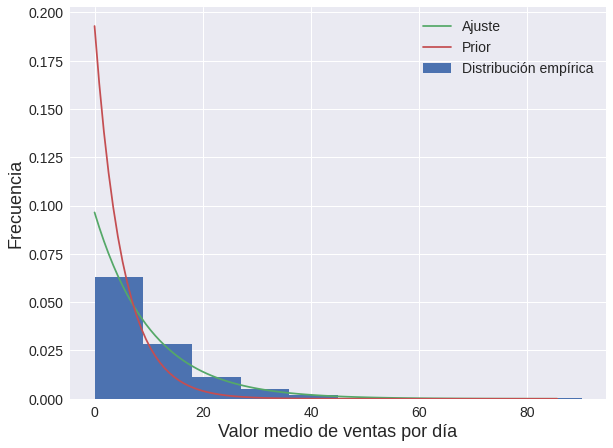

In [20]:
x_model = np.linspace(0,max(x),100)

fig_prior,ax_prior = plt.subplots()
ax_prior.bar(x,mean_distribution,align = 'center',width = width,label= 'Distribución empírica')
ax_prior.plot(x_model,model(x_model,opt_beta),color = '#55A868',label = 'Ajuste')
ax_prior.plot(x_model,model(x_model,opt_beta/2),color = '#C44E52',label = 'Prior')
ax_prior.set(xlabel = 'Valor medio de ventas por día',ylabel = 'Frecuencia')
ax_prior.legend();

### Actualización del prior

Cada dato de ventas en un día que tengo actualizará el prior obtenido, todos los productos empiezan con el mismo prior. Este paso es lento pero solo se debe correr cuando se quiera comenzar a usar el modelo, luego las distribuciones obtenidas pueden guardarse en una base de datos y actualizarse una vez por día.

In [22]:
mu_distribution = np.zeros([N_products,len(x_model)])
mu_distribution[range(len(mu_distribution))] = model(x_model,opt_beta/2)

def poisson(k,mu):
    return mu**k * np.exp(-mu)/np.math.factorial(k)

for p in range(sells_per_day.shape[0]):
    for d in range(sells_per_day.shape[1]):
        mu_distribution[p] = mu_distribution[p] * poisson(sells_per_day[p,d],x_model)
        mu_distribution[p] = mu_distribution[p]/np.sum(mu_distribution[p])

A continuación se muestra cómo la distribución del parámetro $\mu$ queda estimada después de 2 años de venta

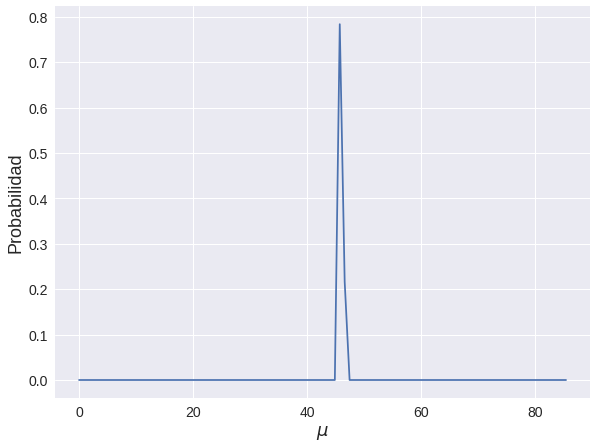

In [23]:
prod = 3
fig_mu, ax_mu = plt.subplots()
ax_mu.plot(x_model,mu_distribution[prod])
ax_mu.set(xlabel = '$\mu$', ylabel = 'Probabilidad');

En el caso en que los datos hayan venido de una distribución de Poisson, la distribución de mu tendrá muy poca incerteza y la distribución generada a partir de ésta será una distribución de Poisson. Si los datos siguen otro tipo de distribución o alguna distribución cercana a la de Poisson, la distribución será más ancha.

A partir del conocimiento sobre el parámetro $\mu$ se realiza un sampleo de ventas obteniendo un número de ventas por día para cada $\mu$ de la distribución, este proceso se repite más veces para los valores de $\mu$ más probables. De esta manera, se obtiene una distribución de ventas a partir del conocimiento sobre el parámetro $\mu$.

Como la reposición de stock no es inmediata, en lugar de preguntar cuál es la probabilidad de terminar el stock hoy es mejor preguntar sobre la probabilidad de terminar el stock en los próximos tres días, este número es un tiempo estimado de envío aunque en un caso real debería setearse diferenciadamente por producto.

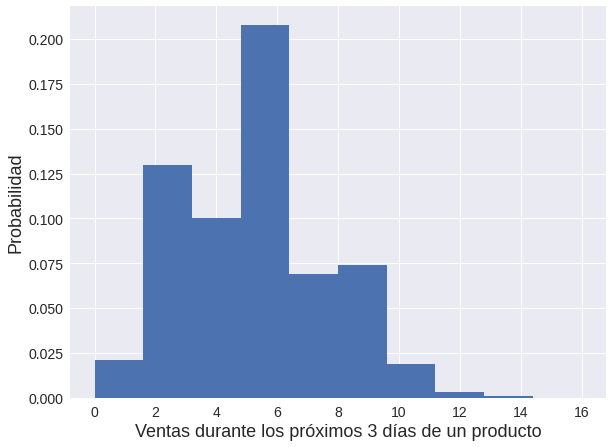

In [24]:
delivery_days = 3
sell_sample_size = 10000
i=False
sell_distribution = []
for p in range(mu_distribution.shape[0]):
    sell_p = []
    for d in range(mu_distribution.shape[1]):
        sell_p.append(np.random.poisson(delivery_days*x_model[d],int(np.round(mu_distribution[p,d]*sell_sample_size))))
    sell_distribution.append(np.concatenate(sell_p))
    while len(sell_distribution[-1]) < sell_sample_size:
        sell_distribution[-1] = np.append(sell_distribution[-1], sell_distribution[-1][-1])
    while len(sell_distribution[-1]) > sell_sample_size:
        sell_distribution[-1] = np.delete(sell_distribution[-1],-1)
sell_distribution = np.array(sell_distribution)
fig_predict,ax_predict= plt.subplots()
ax_predict.hist(sell_distribution[0],density=True);
ax_predict.set(xlabel = f'Ventas durante los próximos {delivery_days} días de un producto', ylabel = 'Probabilidad');

Teniendo la distribución de predicción de ventas, el percentil 90 de la misma responderá cuál es el stock que asegura tener una probabilidad de 0.1 de poder responder a los pedidos que lleguen en esos próximos días (3 en este caso), ese será el stock mínimo que pueda tener cada producto en el depósito.

La elección de percentil 90 también debería depender de la estrategia que quiero tomar con el producto y del tamaño de mi depósito. Una forma de pensar la estrategia de cada producto de manera diferenciada es hacer depender el percentil del factor $\frac{1}{Precio \times Volumen}$, de esta manera los productos más caros y de mayor tamaño usarán percentiles más bajos y así, estrategias más conservadoras, así se evitará guardar stock innecesario de objetos caros y grandes aunque se tenga mayor probabilidad de no poder responder a los pedidos.

en total se guardarán como mínimo 725901 productos dado las estratégias planteadas


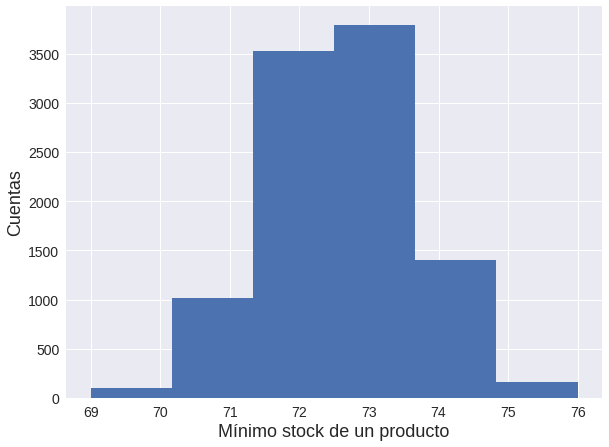

In [25]:
percentile = 90
min_stock = []
for sd in range(sell_distribution.shape[1]):
    min_stock.append(int(np.percentile(sell_distribution[:,sd],percentile)))
    
print(f'en total se guardarán como mínimo {np.sum(min_stock)} productos dado las estratégias planteadas')
fig_minstock,ax_minstock = plt.subplots()
ax_minstock.hist(min_stock,bins = 6)
ax_minstock.set(xlabel = 'Mínimo stock de un producto', ylabel = 'Cuentas');

Para saber cuánto stock debe enviar el vendedor al depósito el cálculo es el mismo, solo que en lugar de pensar en la probabilidad de terminar el stock en los próximos tres días debería pensar en el próximo mes (o en algún otro período de tiempo dependiendo de la frecuencia de reposición deseada). Éste tiempo también podría setearse diferenciadamente por producto teniendo en cuenta la frecuencia con la que se minimicen los costos de envío. También Mercado Libre debe poner un límite a los vendedores que dependa del tamaño del depósito.

### Ventajas y desventajas del modelo

Si la distribución es Poissoneana y estable este modelo funcionará muy bien, la gran ventaja del mismo es que no solo entrega información sobre la esperanza de ventas sino también sobre la varianza. La varianza es sumamente importante en este problema ya que para un producto con alta esperanza y poca varianza, por ejemplo uno que todos los días venda 100 unidades (varianza nula), no sería necesario tener una gran cantidad de productos disponibles, simplemente armar un flujo razonable de entrada y salida de los productos que minimice costos de envíos, incluso no sería un problema, en este caso de alta certeza, terminar un día con 0 unidades de stock si es que ese día ya se vendieron las 100 unidades y al día siguiente entran nuevas. Por otro lado, un producto con baja esperanza y alta varianza necesita tener un stock mínimo grande con respecto a su esperanza porque debería estar preparado para las grandes fluctuaciones. Obviamente estos son casos extremos pero muestran la importancia de la varianza en la estimación y este modelo los contempla.

La desventaja de este modelo es que contempla situaciones estáticas por lo que será malo prediciendo aumentos de la demanda por días especiales, ya sean esperados como inesperados. Para esto es posible usar una técnica de forecasting, en este caso propondría usar una red neuronal recursiva (RNN) sobre la línea de tiempo de ventas por día. 

Una RNN no reemplazaría a este modelo ya que su desventaja es que no predice la varianza de los datos sino que predice su esperanza, de esta manera, ambos modelos se podrían complementar. Una opción para usar ambos modelos a la vez es que a partir de un treshold en el forecasting, el modelo Bayesiano entre en un "modo de alta demanda", de esta manera tendría dos sets de datos para funcionar, el set de datos diario y el set de alta demanda, el modelo se mantendría igual pero usando otro set de datos para la predicción de los días de alta demanda, esto tiene como ventaja que la predicción, a igual cantidad de datos, es más precisa durante todo el año y como desventaja que si se dividen los sets de datos cada set contendrá menos datos.

Otra opción para que ambos modelos convivan es usar el treshold propuesto antes como una alarma para que un equipo manualmente tome las decisiones correctas sobre los pedidos de aumento de stock. Para los casos predecibles como el día de la madre estas alarmas pueden ser programadas sin necesidad de recurrir a la red neuronal.

### Continuación del trabajo

Para que funcione el modelo se deben obtener los datos reales y hacer funcionar el modelo en un servidor guardando las distribuciones de los parámetros en una base de datos y actualizandolo con las ventas de cada día. A su vez, es necesario que el modelo interactúe con la base de datos de stock actual y programar un sistema de notificaciones que avise a cada vendedor cuando uno de sus productos llega al mínimo de stock.

Por otro lado, hay algunas características que se podrían agregar para optimizar las estrategias, ya fue mencionada la incorporación de una RNN para la predicción de días de alta demanda y la diferenciación para productos con diferente $Volumen\times Precio$ y diferentes tiempos de envío.

Otra característica que se puede agregar es la ampliación del treshold de mínimo stock, sería útil que éste no sea un solo valor sino una franja. Esto beneficiaría a los vendedores que tienen varios productos en el depósito, la notificación al vendedor se produciría cuando un producto tenga menos stock que el stock mínimo pero se le notificaría por todos aquellos productos que estén dentro de la franja, de esta manera se reducirían costos de envío y se evitaría notificar al vendedor varios días seguidos.